# Quick Start - Mouse Brain

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/earmingol/scCellFie/blob/main/docs/source/notebooks/quick_start_mouse.ipynb)

In this tutorial, we will use the postnatal mouse brain dataset [(Hochgerner & Zeisel et al 2018)](https://doi.org/10.1038/s41593-017-0056-2) to dissect the metabolic pathways in early development of dentate gyrus. This dataset captures the molecular progression of early neurogenesis and granule cell maturation across P24 and P35. 

## This tutorial includes following steps:
* [Loading libraries](#loading-libraries)
* [Loading mouse brain data](#loading-mouse-brain-data)
* [Run scCellFie](#run-sccellfie)
* [Export results](#export-results)
* [Identification of metabolic task markers & visualization](#identification-of-metabolic-task-markers-and-visualization)

## Loading libraries <a class="anchor" id="loading-libraries"></a>

In [1]:
import sccellfie
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import glasbey

import textwrap

## To avoid warnings
import warnings
warnings.filterwarnings("ignore")

/software/cellgen/team283/tl7/envs/scvi-env/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/software/cellgen/team283/tl7/envs/scvi-env/lib/python3.12/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


## Loading mouse brain data <a class="anchor" id="loading-mouse-brain-data"></a>

The Postnatal Dentate Gyrus datset contains 2930 cells `(n_obs)` with 13913 genes `(n_vars)`.

This is a processed data including 14 cell type annotations in `.obs['clusters']`, and 22 subclusters of cell type annotations in `.obs['clusters_enlarged']`. For demonstration purpose, this tutorial will use the `.obs['clusters']` cell labels.

In [ ]:
adata = sc.read(filename='./data/MusMusculus_DentateGyrus.h5ad', 
                backup_url='https://cell2fate.cog.sanger.ac.uk/DentateGyrus/DentateGyrus_anndata.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 2930 × 13913
    obs: 'clusters', 'age(days)', 'clusters_enlarged'
    uns: 'clusters_colors'
    obsm: 'X_umap'
    layers: 'ambiguous', 'spliced', 'unspliced'

<div class="alert alert-info">
<b>Note!</b>

As shown in the output, this AnnData also contains raw count matrices of `spliced` (exonic) and `unspliced` (intronic) in `.layers` which are presented explicitly for velocity analysis. 
The `ambiguous` matrix contains reads overlapping exon-intron boundaries. 

Please visit this [10X Analysis Guides](https://www.10xgenomics.com/analysis-guides/trajectory-analysis-using-10x-Genomics-single-cell-gene-expression-data) for the details.

</div>

In this tutorial, we will copy `.layers['spliced']` into the `.X` as raw spliced counts are normally used in gene expression analysis.

In [8]:
adata.X = adata.layers['spliced'].copy()

## Run scCellFie <a class="anchor" id="run-sccellfie"></a>

In current version, scCellFie supports `human` or `mouse` specific metabolic pathways. We will select `organism='mouse'` for the analysis.

In [ ]:
results = sccellfie.run_sccellfie_pipeline(adata,
                                           organism='mouse', 
                                           sccellfie_data_folder=None,
                                           n_counts_col=None, # Total counts per cell will be computed if left as None, 
                                           process_by_group=False, # Whether to do the processing by cell groups
                                           groupby=None, # Column indicating cell groups if `process_by_group=True`
                                           neighbors_key='neighbors', # Neighbors information if precomputed. Otherwise, it will be computed here
                                           n_neighbors=10, # Number of neighbors to use
                                           batch_key=None, # there is no batch_key in this dataset 
                                           threshold_key='sccellfie_threshold',  # This is for using the default database. If personalized thresholds are used, specificy column name
                                           smooth_cells=True, # Whether to perform gene expression smoothing before running the tool
                                           alpha=0.33, # Importance of neighbors' expression for the smoothing (0 to 1)
                                           chunk_size=5000, # Number of chunks to run the processing steps (helps with the memory)
                                           disable_pbar=False, 
                                           save_folder=None, # In case results will be saved. If so, results will not be returned and should be loaded from the folder (see sccellfie.io.load_data function
                                           save_filename=None # Name for saving the files, otherwise a default name will be used
                                          )


==== scCellFie Pipeline: Initializing ====
Loading scCellFie database for organism: mouse

==== scCellFie Pipeline: Processing entire dataset ====

---- scCellFie Step: Preprocessing data ----

---- scCellFie Step: Computing neighbors ----

---- scCellFie Step: Preparing inputs ----
Gene names corrected to match database: 9
Shape of new adata object: (2930, 654)
Number of GPRs: 603
Shape of tasks by genes: (197, 654)
Shape of reactions by genes: (603, 654)
Shape of tasks by reactions: (197, 603)

---- scCellFie Step: Smoothing gene expression ----


Smoothing Expression: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]



---- scCellFie Step: Computing gene scores ----

---- scCellFie Step: Computing reaction activity ----


Cell Rxn Activities: 100%|██████████| 2930/2930 [00:19<00:00, 150.48it/s]



---- scCellFie Step: Computing metabolic task activity ----
Removed 1 metabolic tasks with zeros across all cells.

==== scCellFie Pipeline: Processing completed successfully ====


## Export results <a class="anchor" id="export-results"></a>

In [10]:
results.keys()

dict_keys(['adata', 'gpr_rules', 'task_by_gene', 'rxn_by_gene', 'task_by_rxn', 'rxn_info', 'task_info', 'thresholds', 'organism'])

To access metabolic activities, we need to inspect ``results['adata']``:

- The processed single-cell data is located in the AnnData object ``results['adata']``.
- The reaction activities for each cell are located in the AnnData object ``results['adata'].reactions``.
- The metabolic task activities for each cell are located in the AnnData object ``results['adata'].metabolic_tasks``.

In particular:

- ``results['adata']``: contains gene expression in ``.X``.
- ``results['adata'].layers['gene_scores']``: contains gene scores as in the original CellFie paper.
- ``results['adata'].uns['Rxn-Max-Genes']``: contains determinant genes for each reaction per cell.
- ``results['adata'].reactions``: contains reaction scores in ``.X`` so every scanpy function can be used on this object to visualize or compare values.
- ``results['adata'].metabolic_tasks``: contains metabolic task scores in ``.X`` so every scanpy function can be used on this object to visualize or compare values.

Other keys in the ``results`` dictionary are associated with the scCellFie database and are already filtered for the elements present
in the dataset (``'gpr_rules'``, ``'task_by_gene'``, ``'rxn_by_gene'``, ``'task_by_rxn'``, ``'rxn_info'``, ``'task_info'``, ``'thresholds'``, ``'organism'``).

### Save single-cell results

We can save our single-cell results contained in the AnnData objects (``results['adata']``) into a specific folder. Here we only need to specify the output folder, and the basename that our AnnData objects will have. This function below saves the expression object (``results['adata']``) and those containing scores for reactions and metabolic tasks (``results['adata'].reactions`` and ``results['adata'].metabolic_tasks``, respectively), as separate files.

In [ ]:
sccellfie.io.save_adata(adata=results['adata'], output_directory='./results/', filename='Mouse_DentateGyrus_scCellFie')

## Identification of metabolic task markers and visualization <a class="anchor" id="identification-of-metabolic-task-markers-and-visualization"></a>

To identify markers, we can use different approaches. Here we show an approach based on [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), which comes from the Natural Language Processing field, and the [logistic regression implemented in Scapy](https://www.nature.com/articles/s41592-018-0303-9).

In [ ]:
# Column indicating the cell types in the adata.obs dataframe
cell_group = 'clusters'

In [ ]:
# We use glasbey to expand the palette into a larger number of colors
# This is useful when we have many cell types
palette = glasbey.extend_palette('Set2', 
                                 palette_size=max([10, results['adata'].metabolic_tasks.obs[cell_group].unique().shape[0]]))

### Detection using TF-IDF

scCellFie runs a TF-IDF approach, as implemented in the tool SoupX in R.
We define a `express_cut=5*np.log(2)` to define cells expressing each metabolic task. Here, a value of `5*np.log(2)` indicates that all reactions in the task are over the threshold value of the determinant gene (or "active"). This condition is often rare in single-cell data due to data sparsity (rarely all reactions in a task are over their determinant gene's threshold), but it is a good approach for identifying markers.

In [13]:
mrks = sccellfie.external.quick_markers(results['adata'].metabolic_tasks,
                                        cluster_key=cell_group, 
                                        n_markers=20, 
                                        express_cut=5*np.log(2))

In [14]:
mrks.head()

gene     cluster        tf  \
0                                   Serine synthesis  Astrocytes  0.508333   
1                                  Glycine synthesis  Astrocytes  0.383333   
2           Homocysteine synthesis (need methionine)  Astrocytes  0.208333   
3                         Synthesis of methylglyoxal  Astrocytes  0.475000   
4  Conversion of estrone (E1) to estradiol-17beta...  Astrocytes  0.183333   

        idf    tf_idf  gene_frequency_outside_cluster  gene_frequency_global  \
0  3.613310  1.836766                        0.006406               0.026962   
1  4.090937  1.568193                        0.001068               0.016724   
2  4.031514  0.839899                        0.009609               0.017747   
3  1.609438  0.764483                        0.188256               0.200000   
4  4.111557  0.753785                        0.009253               0.016382   

   second_best_tf second_best_cluster          pval          qval  
0        0.098039    Radial Glia-like  5.716346e-76  5.716346e-76  
1        0.039216    Radial Glia-like  1.645812e-64  1.645812e-64  
2        0.117647    Radial Glia-like  3.070266e-22  3.070266e-22  
3        0.475000          Astrocytes  3.830393e-12  3.282879e-12  
4        0.078431    Radial Glia-like  4.792421e-19  4.792421e-19

By looking at the distributions given each task TF-IDF scores, we can do some filtering to ensure more specific tasks.

<Axes: >

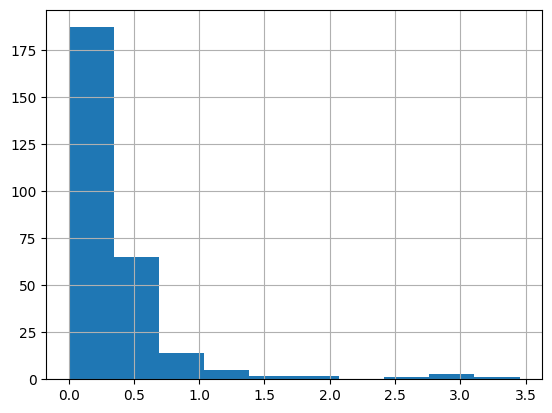

In [15]:
mrks['tf_idf'].hist()

Text(0, 0.5, 'IDF')

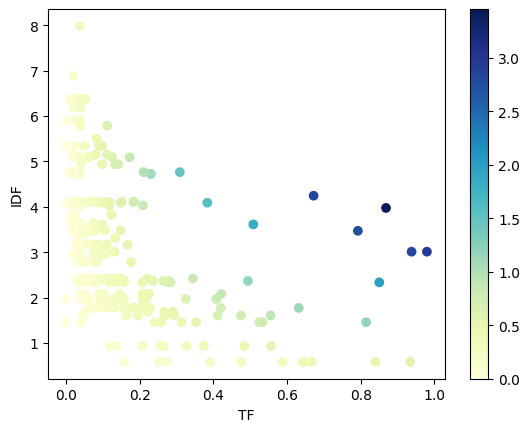

In [16]:
scatter = plt.scatter(mrks['tf'], mrks['idf'], c=mrks['tf_idf'], cmap='YlGnBu')
plt.colorbar(scatter)
plt.xlabel('TF')
plt.ylabel('IDF')

scCellFie includes a filtering function that fits a hyperbolic curve, while the user can define some thresholds based on the tf-idf scores, and the ratio between the top and second best cell clusters (`tf_ratio`).

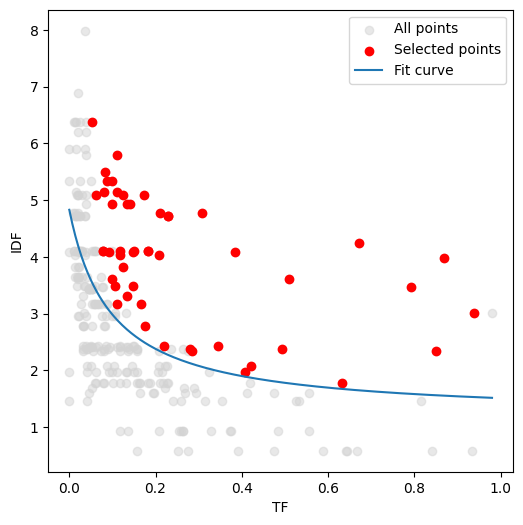

In [17]:
x_col = 'tf'
y_col = 'idf'
df = mrks
tfidf_threshold = 0.3
tf_ratio = 1.2

# Visualization
plt.figure(figsize=(6, 6))

# Plot all points
plt.scatter(df[x_col], df[y_col], alpha=0.5, c='lightgray', label='All points')

# Plot selected points
filtered_mrks, curve = sccellfie.external.filter_tfidf_markers(df, tf_col=x_col, idf_col=y_col, tfidf_threshold=tfidf_threshold, tf_ratio=tf_ratio)

plt.scatter(filtered_mrks[x_col], filtered_mrks[y_col], c='red', label='Selected points')
plt.plot(*curve, label='Fit curve')

plt.xlabel('TF')
plt.ylabel('IDF')
plt.legend()

In [18]:
tf_idf_mrks = filtered_mrks['gene'].unique().tolist()
len(tf_idf_mrks)

38

Here we identified a number of metabolic markers, which we can visualize using regular UMAP visualizations.

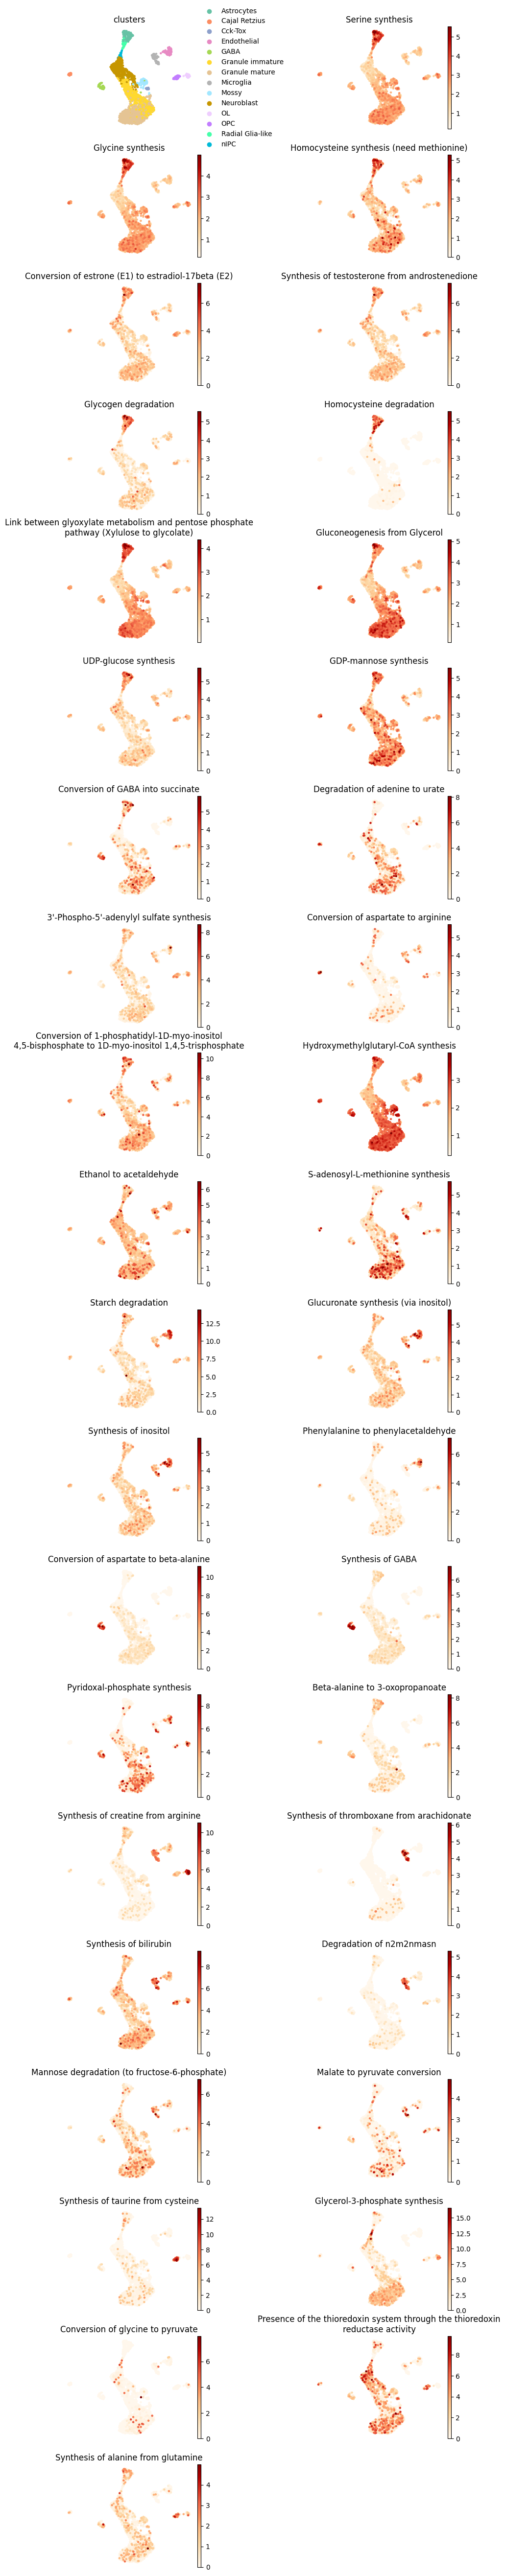

In [19]:
plt.rcParams['figure.figsize'] = (3,3)
plt.rcParams['font.size'] = 10

sc.pl.embedding(results['adata'].metabolic_tasks,
                color=[cell_group] + tf_idf_mrks,
                ncols=2,
                palette=palette,
                frameon=False,
                basis='X_umap',
                wspace=0.7,
                title=["\n".join(textwrap.wrap(t, width=60)) for t in [cell_group] + tf_idf_mrks],
                cmap='OrRd'
               )

We can further inspect the metabolic score distribution across single cells per cell type for these markers.

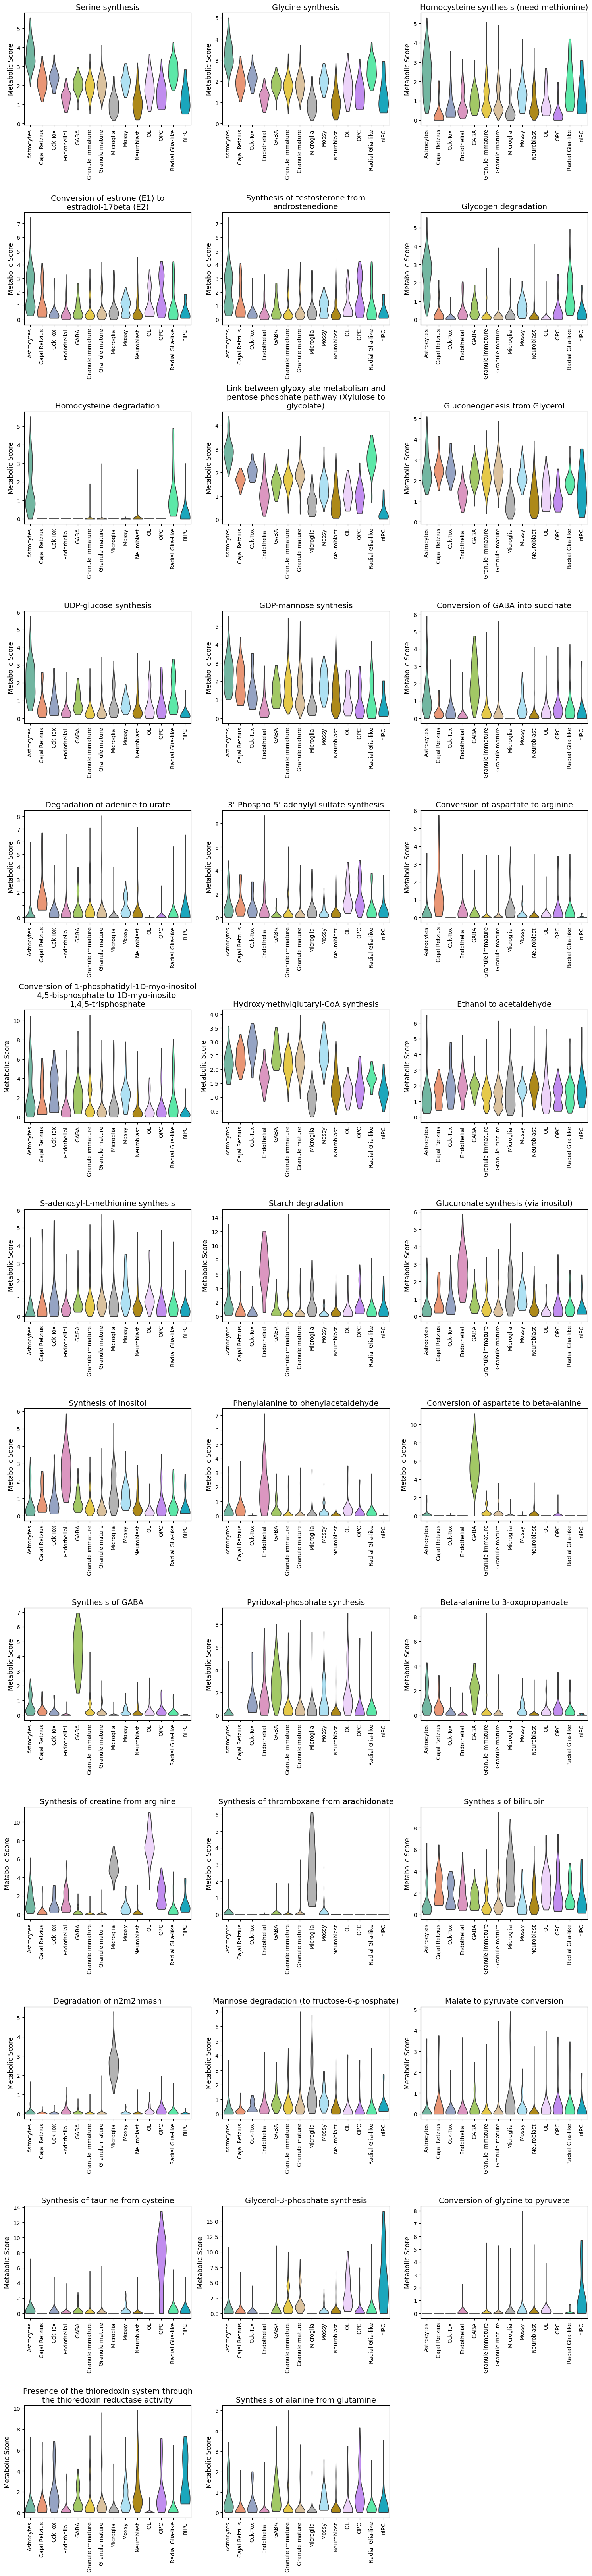

In [20]:
fig, axes = sccellfie.plotting.create_multi_violin_plots(results['adata'].metabolic_tasks,
                                                         features=tf_idf_mrks,
                                                         groupby=cell_group,
                                                         stripplot=False,
                                                         n_cols=3,
                                                         ylabel='Metabolic Score'
                                                        )

### Detection using Logistic Regression in Scanpy

Similarly, we can use another approach for identifying metabolic markers. In this case, a logistic regression implemented in Scanpy.

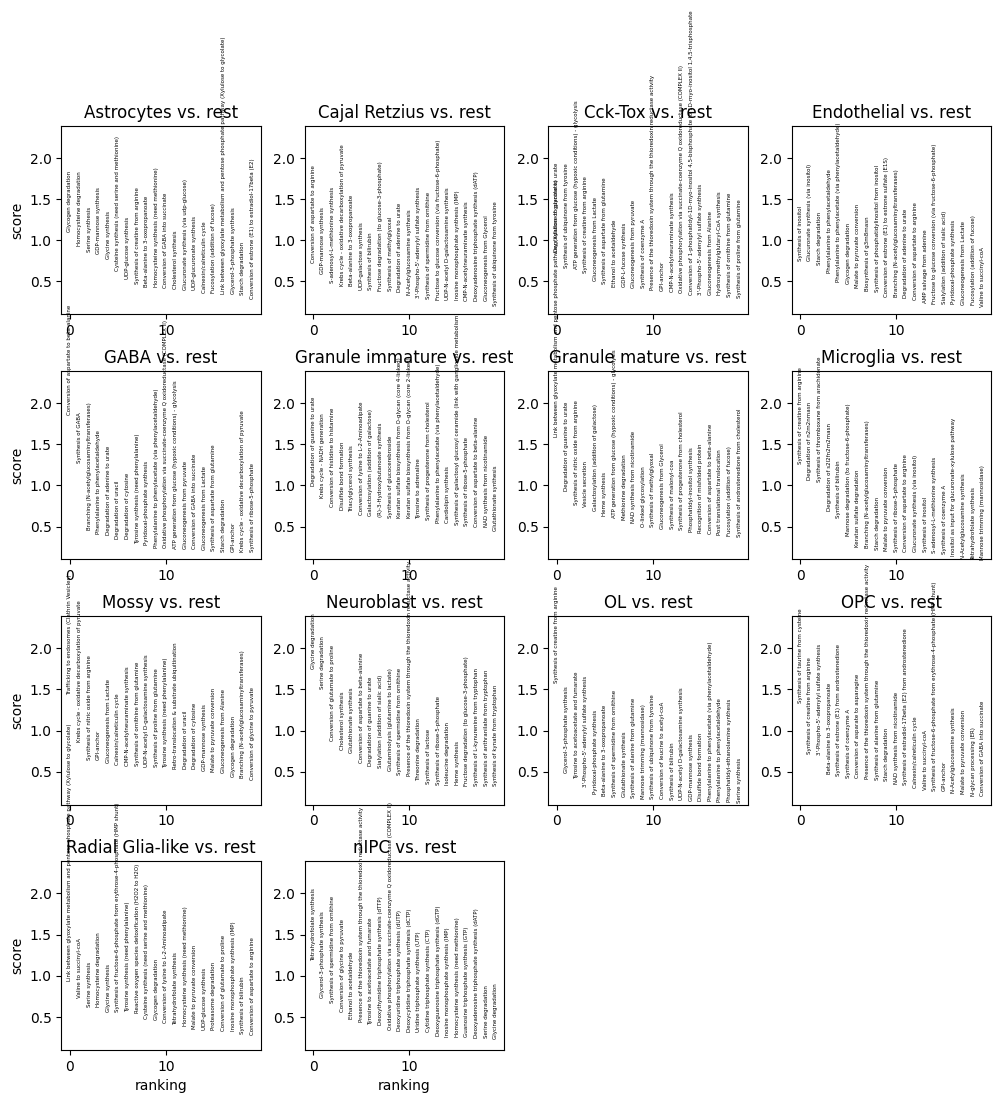

In [21]:
method = 'logreg'
sc.tl.rank_genes_groups(results['adata'].metabolic_tasks, cell_group, method=method,
                        use_raw=False, key_added = method)

sc.pl.rank_genes_groups(results['adata'].metabolic_tasks, n_genes=20, sharey=True, key=method, fontsize=4)

In [22]:
scanpy_df = sc.get.rank_genes_groups_df(results['adata'].metabolic_tasks,  
                                          key=method, 
                                          group=None) 

In this case we can also inspect them using dot plots.

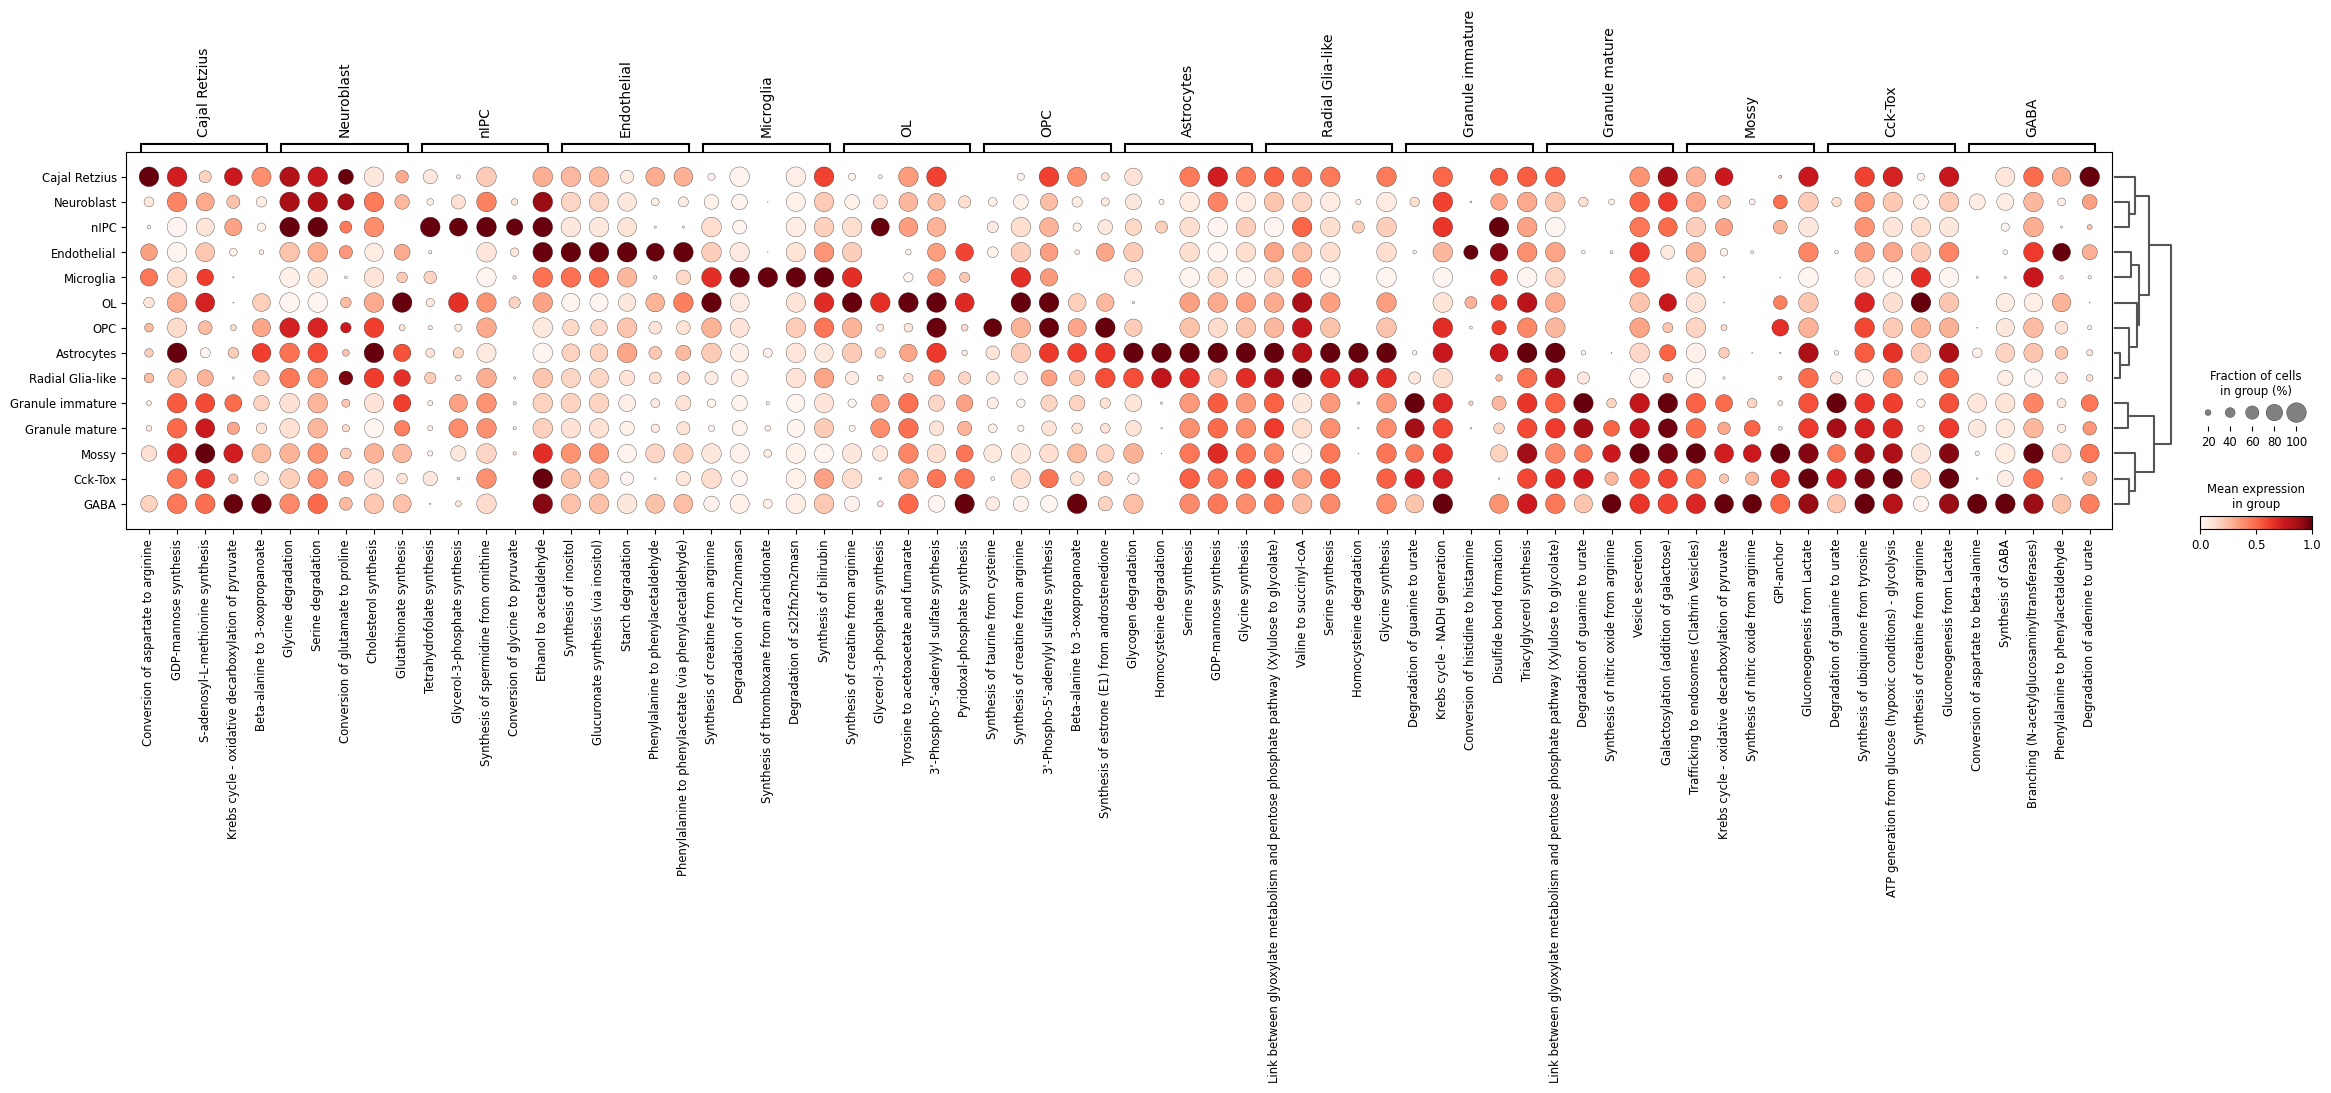

In [23]:
sc.pl.rank_genes_groups_dotplot(results['adata'].metabolic_tasks, n_genes=5, groupby=cell_group, 
                                key=method, use_raw=False, standard_scale='var',
                               )

We can further filter the metabolic tasks given the scores assigned by the logistic regression model.

<Axes: >

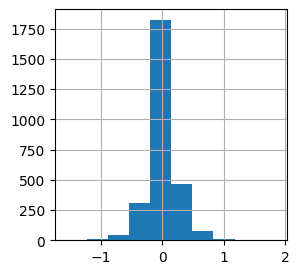

In [24]:
scanpy_df['scores'].hist()

In [25]:
scores_threshold = 1.0

sc_markers_df = scanpy_df
scanpy_markers = sc_markers_df.loc[sc_markers_df['scores'] > scores_threshold]['names'].unique().tolist()
len(scanpy_markers)

12

And perform the same visualizations.

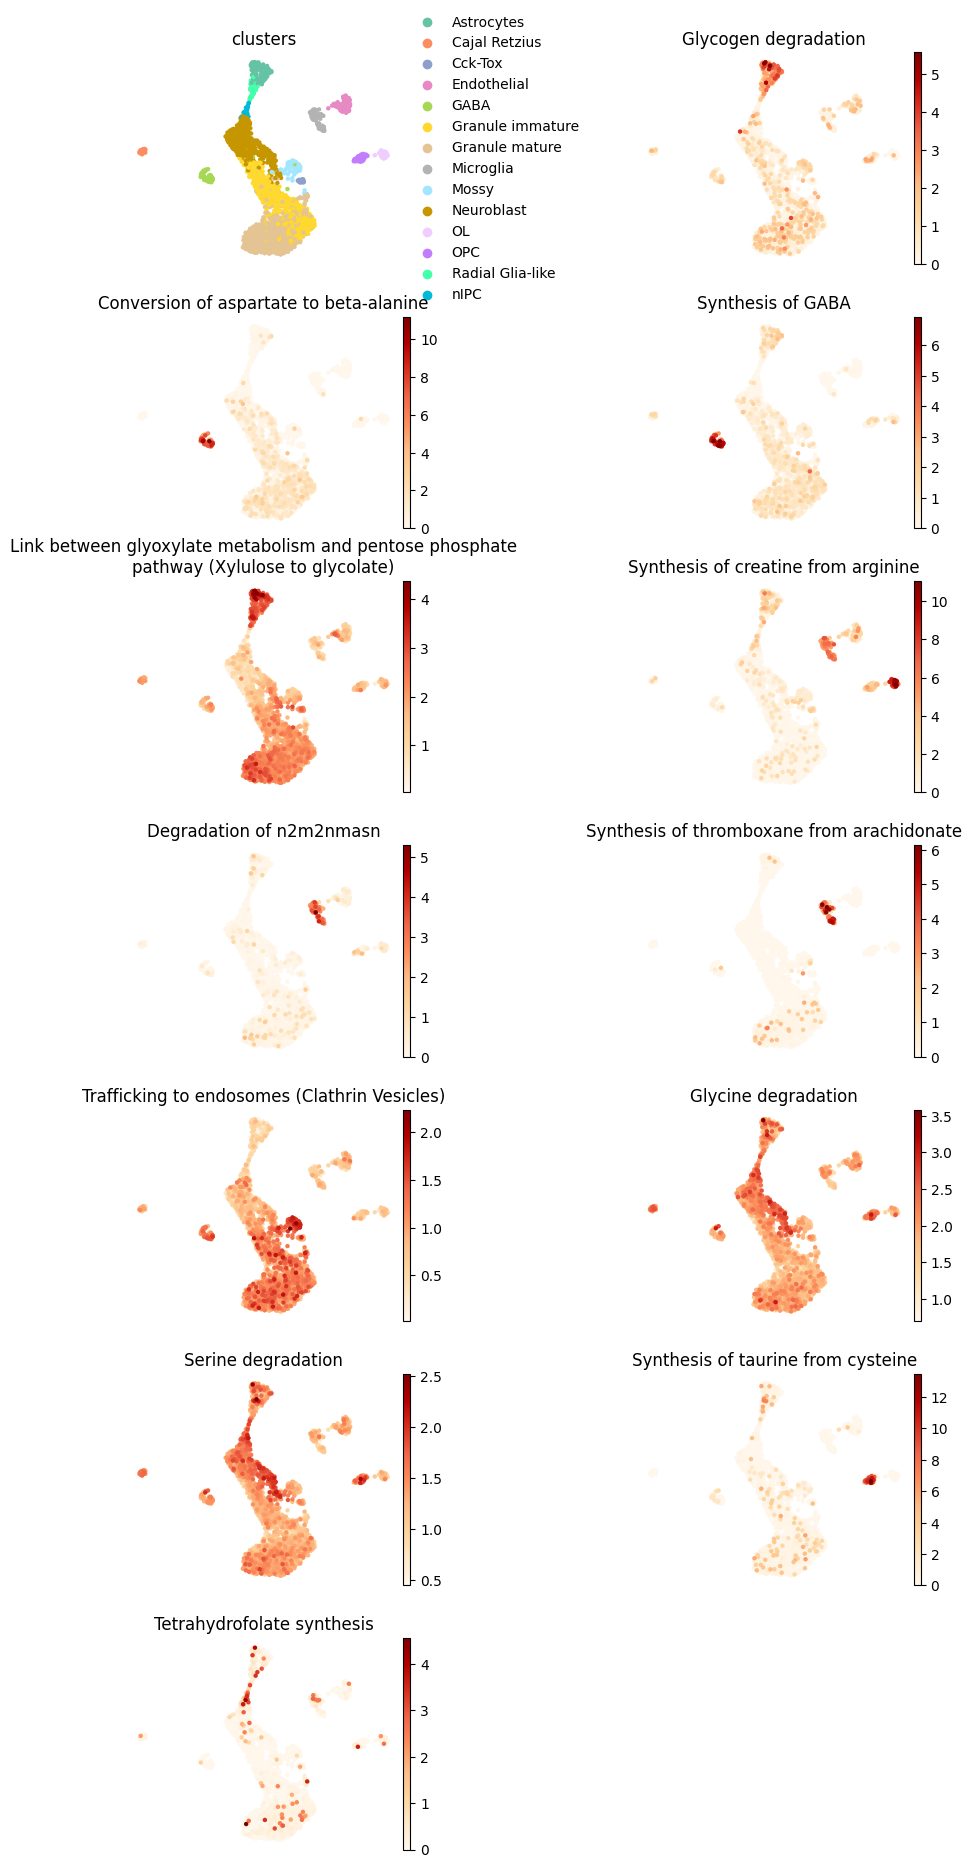

In [26]:
plt.rcParams['figure.figsize'] = (3,3)
plt.rcParams['font.size'] = 10

sc.pl.embedding(results['adata'].metabolic_tasks,
                color=[cell_group] + scanpy_markers,
                ncols=2,
                palette=palette,
                frameon=False,
                basis='X_umap',
                wspace=0.7,
                cmap='OrRd',
                title=["\n".join(textwrap.wrap(t, width=60)) for t in [cell_group] + scanpy_markers],
               )

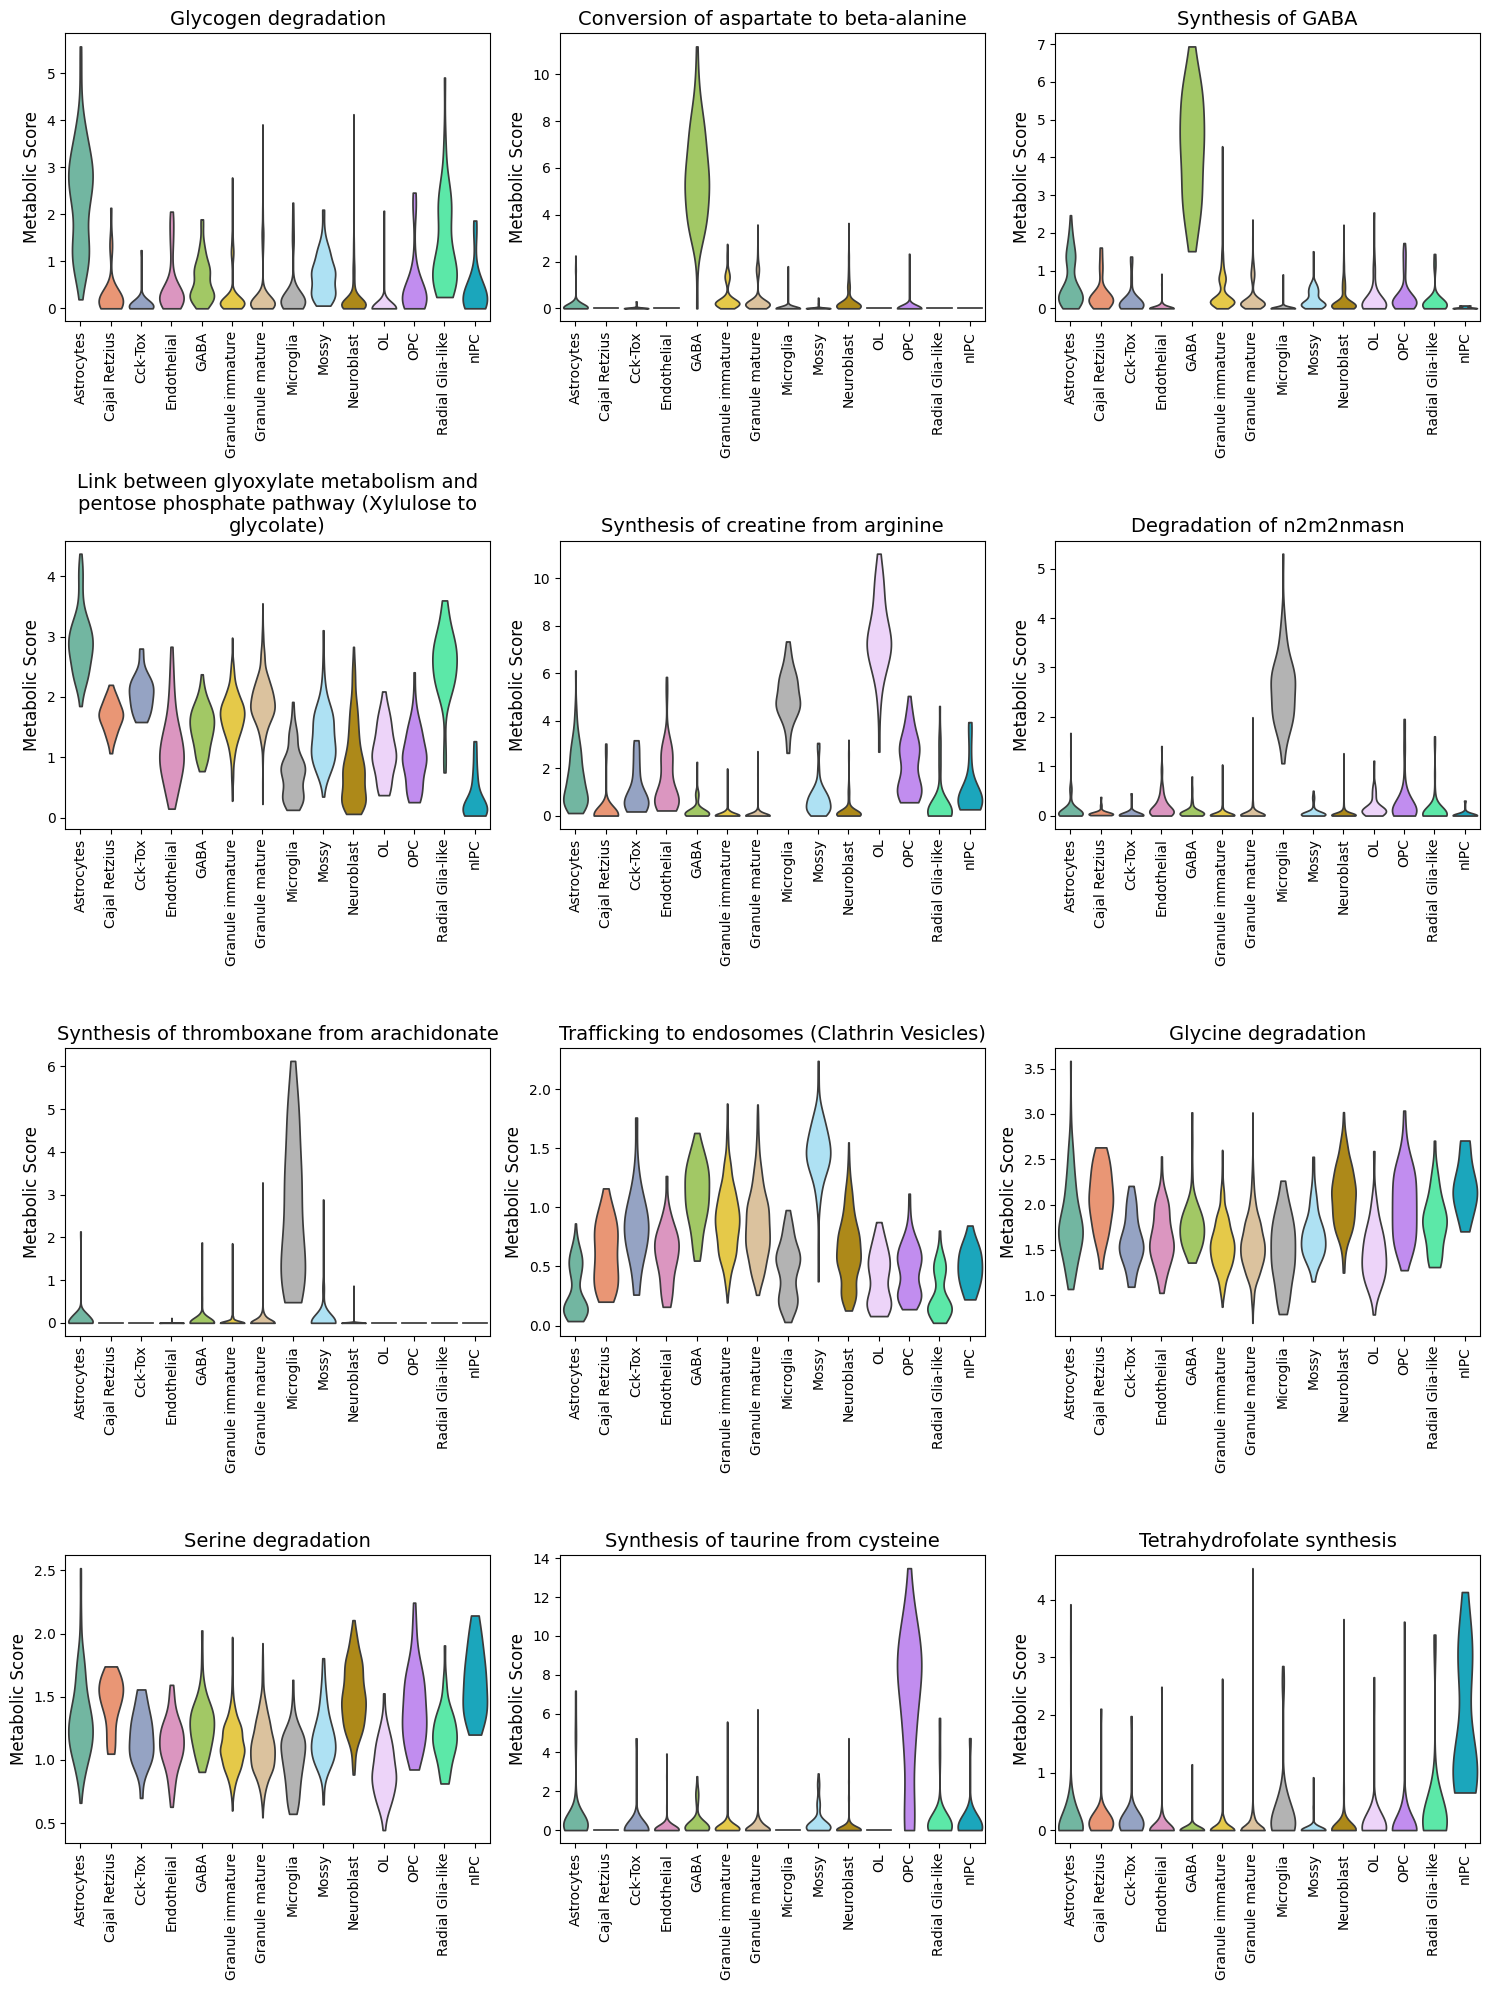

In [27]:
fig, axes = sccellfie.plotting.create_multi_violin_plots(results['adata'].metabolic_tasks,
                                                         features=scanpy_markers,
                                                         groupby=cell_group,
                                                         stripplot=False,
                                                         n_cols=3,
                                                         ylabel='Metabolic Score'
                                                        )

### Visualise Markers from both methods

We can combine the metabolic tasks from different approaches too:

In [28]:
both_markers = sorted(set(tf_idf_mrks + scanpy_markers))
len(both_markers)

42

#### Select only highly active markers

And if we'd like to, we can filter them given their activity level. Here, we first aggregate the metabolic activity of the markers into a cell-type level.

In [29]:
agg = sccellfie.expression.aggregation.agg_expression_cells(results['adata'].metabolic_tasks[:, both_markers],
                                                            groupby=cell_group, 
                                                            agg_func='trimean')

Then, we filter markers given ther average activity (trimean). Our threshold here was an aggregated score of 1 in at least one cell type.

In [30]:
both_markers = agg.T.loc[(agg.T > 1.).any(axis=1)].index.tolist()
len(both_markers)

39

And finally, visualize both markers that are "more active".

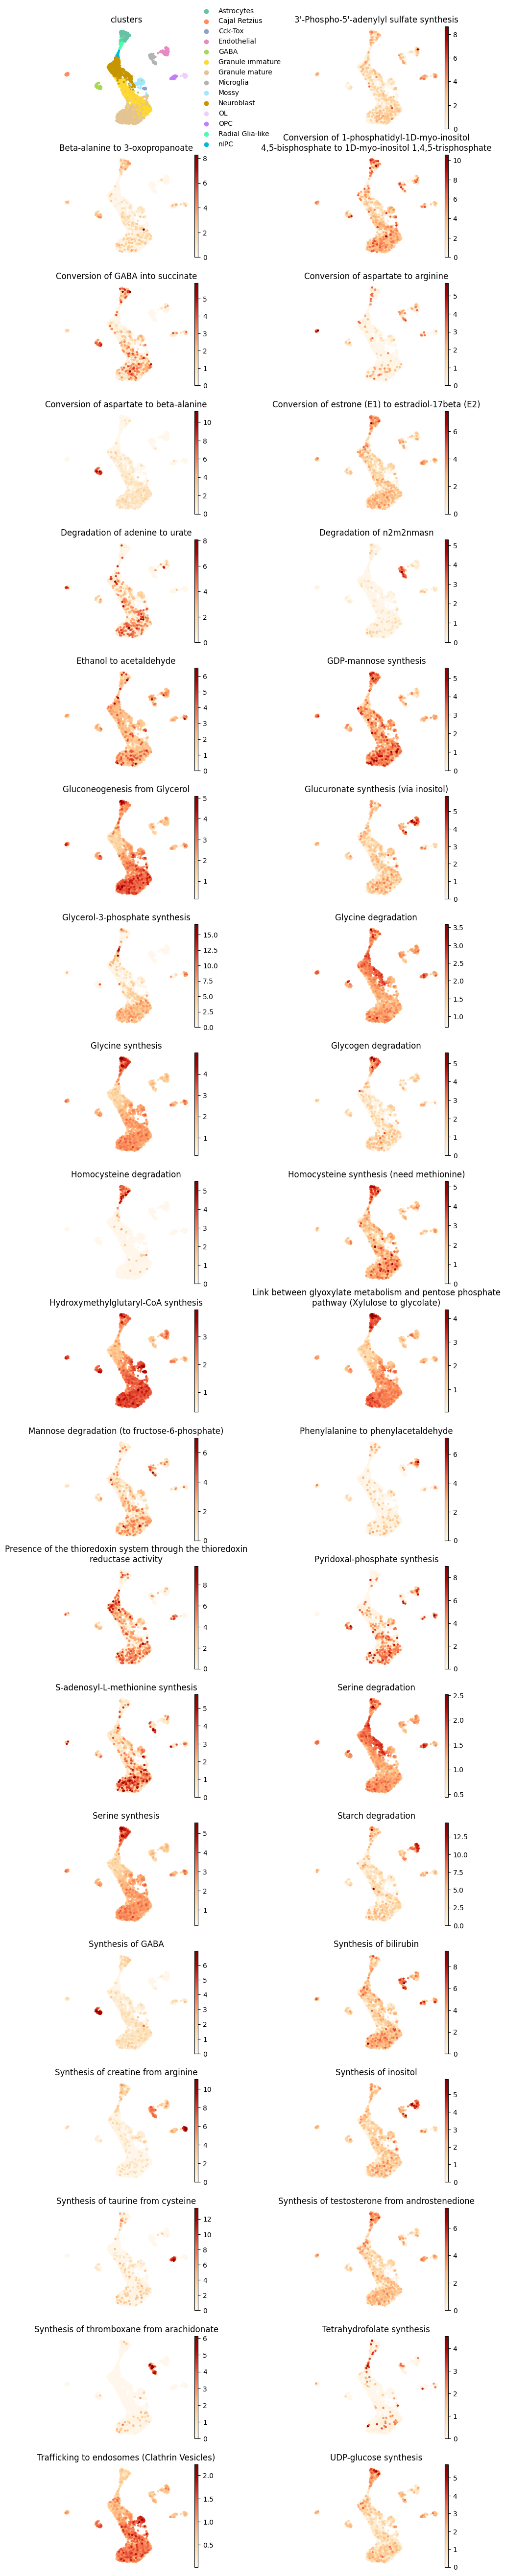

In [31]:
plt.rcParams['figure.figsize'] = (3,3)
plt.rcParams['font.size'] = 10

sc.pl.embedding(results['adata'].metabolic_tasks,
                color=[cell_group] + both_markers,
                ncols=2,
                palette=palette,
                frameon=False,
                basis='X_umap',
                wspace=0.7,
                cmap='OrRd',
                title=["\n".join(textwrap.wrap(t, width=60)) for t in [cell_group] + both_markers],
               )

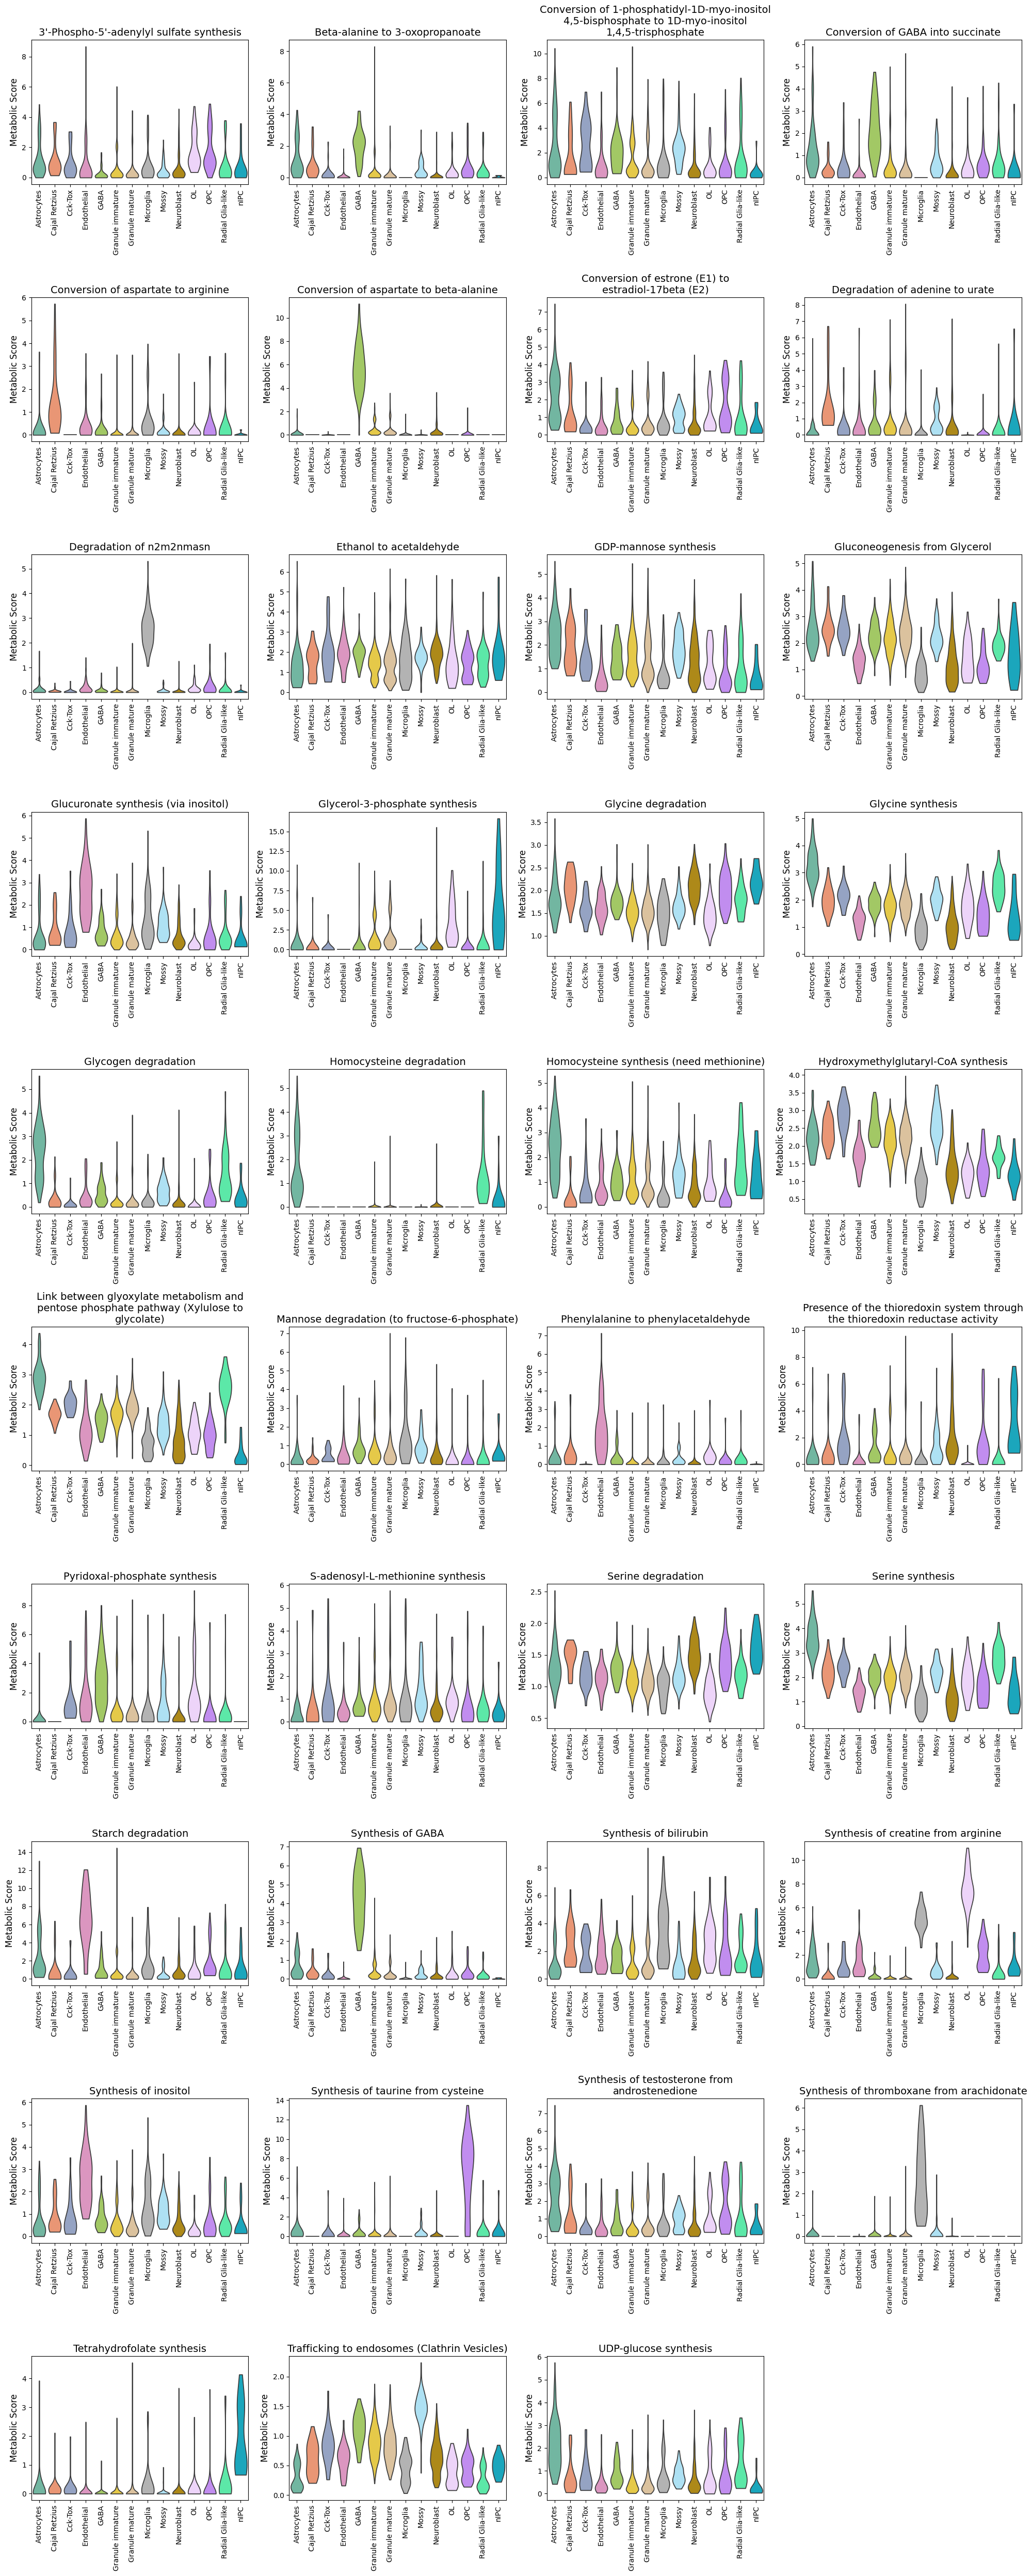

In [32]:
fig, axes = sccellfie.plotting.create_multi_violin_plots(results['adata'].metabolic_tasks,
                                                         features=both_markers,
                                                         groupby=cell_group,
                                                         stripplot=False,
                                                         n_cols=4,
                                                         ylabel='Metabolic Score'
                                                        )